# Peak rainfall time

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
#from dask.distributed import Client
from matplotlib import cm
from os.path import exists
from scipy.stats import circmean

ProgressBar().register()
#client = Client()
lonlat = ccrs.PlateCarree()

Data location:

In [2]:
var = 'pr'
period = slice('2018-12-01','2019-01-31')

urlbase = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa'
urls = {
  'UCAN-WRF433' :
     f'{urlbase}/output/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/1hr/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_1hr',
  'USP-RegCM471' :
     f'{urlbase}/output/CORDEX/output/CSAM-4i/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/3hr/CORDEX_output_CSAM-4i_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_3hr', 
  'ERA5' :
     f'{urlbase}/reanalysis/ERA5-CSAM-4i_1hr',
  'MSWX' :
     f'{urlbase}/observations/CSAM-4i_GloH2O-MSWX_3hr'
}

Data loaded from cache: cache/hmax_pr_UCAN-WRF433.nc
Data loaded from cache: cache/hmax_pr_USP-RegCM471.nc
Data loaded from cache: cache/hmax_pr_ERA5.nc
Data loaded from cache: cache/hmax_pr_MSWX.nc


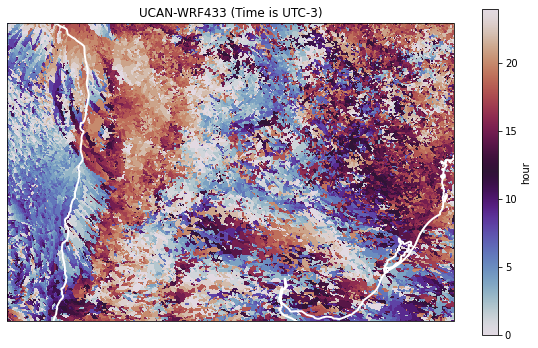

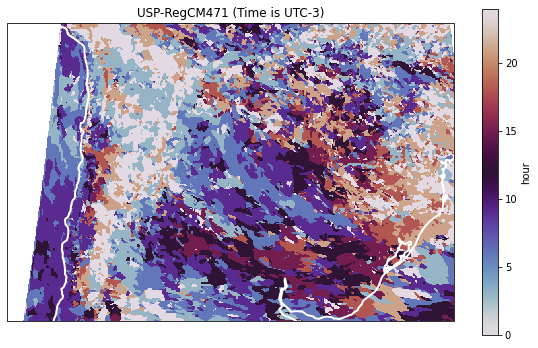

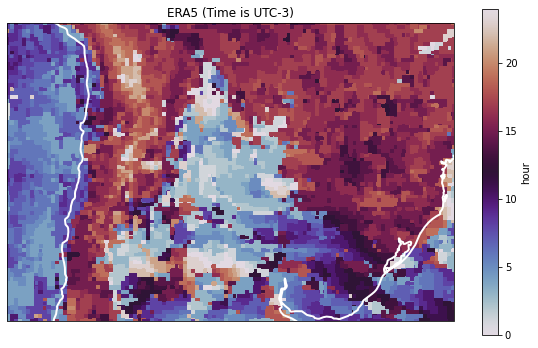

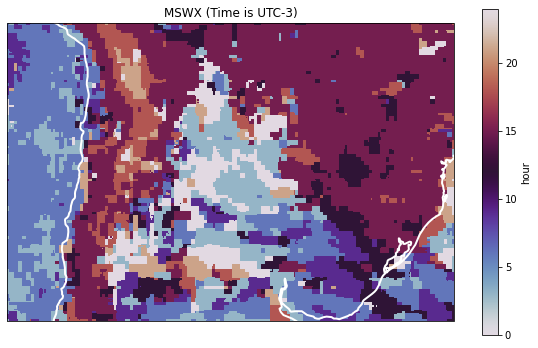

In [8]:
for dataset in urls.keys():
  nc = f'cache/hmax_{var}_{dataset}.nc'
  if exists(nc):
    hmax = xr.open_dataset(nc)['hour']
    print(f'Data loaded from cache: {nc}')
  else:
    ds = xr.open_dataset(urls[dataset], chunks = dict(time = 100, lon = 100, lat = 100))
    dcycle = (ds.pr
      .sel(dict(time=period))
      .groupby('time.hour')
      .mean('time')
    )
    hmax = dcycle.idxmax('hour').compute()
    hmax.to_netcdf(nc, format = 'NETCDF4', encoding={'hour':{'zlib':True}})
  # Plot
  f = plt.figure(figsize=(10,6))
  p = ((hmax-3)%24).plot(vmin=0, vmax=24, cmap=cm.twilight, transform=lonlat, subplot_kws = dict(projection=lonlat))
  l = p.axes.add_feature(cfea.COASTLINE, linewidth=2, edgecolor = 'white')
  t = plt.title(f'{dataset} (Time is UTC-3)')